In [72]:
from math import sqrt
from numpy import concatenate
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from tensorflow.keras.models import load_model
from keras.layers import Dense, Masking
from keras.layers import LSTM
from tensorflow.keras import callbacks as cb
from keras.wrappers.scikit_learn import KerasRegressor
import tensorflow as tf
from hydro_helpers.scoring import render_score
from hydro_helpers.reporting import cv_report
from hydro_helpers._utils import _nse as NSE
from hydro_helpers._utils import _rmse as RMSE
mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False
tf.random.set_seed(13)

In [88]:
river = 'lena'
df = pd.read_csv('data/lena/train_stage.txt', index_col='date')
print(len(df))
df = df.dropna(how='all')
print(df.mean(axis=0))
df.head()

12279
stage_max_3019     66.353757
stage_max_3021    183.922699
stage_max_3024    188.487849
stage_max_3027    154.081966
stage_max_3028    314.481845
stage_max_3029    219.955208
stage_max_3030    213.045091
stage_max_3031    180.660280
stage_max_3032    218.816435
stage_max_3035    188.793224
stage_max_3036    300.326655
stage_max_3037    249.928958
stage_max_3038    338.659093
stage_max_3041    224.981595
stage_max_3042    247.754785
stage_max_3045    -44.393355
stage_max_3047    246.343747
stage_max_3048    516.919643
stage_max_3050    289.277919
stage_max_3087    197.533264
stage_max_3106    155.046071
stage_max_3169    322.521867
stage_max_3180    319.660707
stage_max_3229    312.231660
stage_max_3230    346.041380
stage_max_3554    331.700840
stage_max_3555    465.227301
dtype: float64


,stage_max_3019,stage_max_3021,stage_max_3024,stage_max_3027,stage_max_3028,stage_max_3029,stage_max_3030,stage_max_3031,stage_max_3032,stage_max_3035,...,stage_max_3048,stage_max_3050,stage_max_3087,stage_max_3106,stage_max_3169,stage_max_3180,stage_max_3229,stage_max_3230,stage_max_3554,stage_max_3555
date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,-23.0,103.0,106.0,25.0,258.0,51,126.0,152.0,143,59,...,NaN,158.0,144.0,94.0,109,234.0,126.0,150.0,311.0,182.0
1985-01-02,-23.0,103.0,106.0,23.0,258.0,49,122.0,150.0,141,58,...,NaN,157.0,144.0,90.0,109,234.0,126.0,149.0,310.0,188.0
1985-01-03,-23.0,102.0,106.0,21.0,255.0,47,120.0,147.0,140,57,...,NaN,155.0,144.0,89.0,109,233.0,124.0,148.0,309.0,193.0
1985-01-04,-24.0,102.0,106.0,19.0,252.0,45,119.0,146.0,139,55,...,NaN,154.0,144.0,87.0,108,232.0,120.0,146.0,309.0,197.0
1985-01-05,-24.0,102.0,106.0,17.0,251.0,43,119.0,145.0,135,53,...,NaN,153.0,144.0,86.0,108,231.0,115.0,144.0,308.0,197.0


In [104]:
print(df.isna().sum())
df = df.apply(lambda x: x.fillna(x.mean()),axis=0)
print(df.isna().sum())

stage_max_3019    0
stage_max_3021    0
stage_max_3024    0
stage_max_3027    0
stage_max_3028    0
stage_max_3029    0
stage_max_3030    0
stage_max_3031    0
stage_max_3032    0
stage_max_3035    0
stage_max_3036    0
stage_max_3037    0
stage_max_3038    0
stage_max_3041    0
stage_max_3042    0
stage_max_3045    0
stage_max_3047    0
stage_max_3048    0
stage_max_3050    0
stage_max_3087    0
stage_max_3106    0
stage_max_3169    0
stage_max_3180    0
stage_max_3229    0
stage_max_3230    0
stage_max_3554    0
stage_max_3555    0
dtype: int64
stage_max_3019    0
stage_max_3021    0
stage_max_3024    0
stage_max_3027    0
stage_max_3028    0
stage_max_3029    0
stage_max_3030    0
stage_max_3031    0
stage_max_3032    0
stage_max_3035    0
stage_max_3036    0
stage_max_3037    0
stage_max_3038    0
stage_max_3041    0
stage_max_3042    0
stage_max_3045    0
stage_max_3047    0
stage_max_3048    0
stage_max_3050    0
stage_max_3087    0
stage_max_3106    0
stage_max_3169    0
stage_m

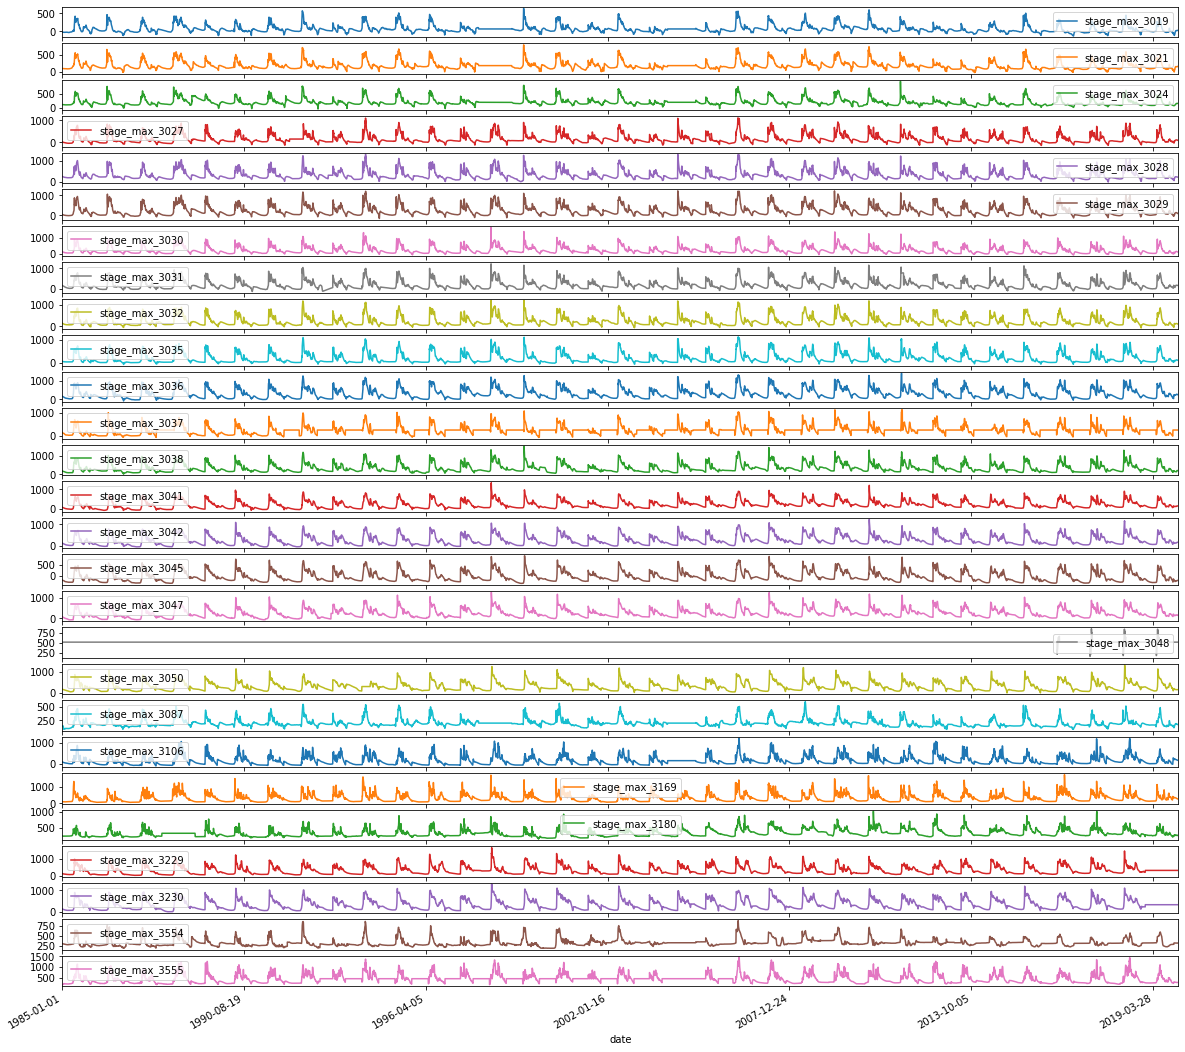

,stage_max_3019,stage_max_3021,stage_max_3024,stage_max_3027,stage_max_3028,stage_max_3029,stage_max_3030,stage_max_3031,stage_max_3032,stage_max_3035,stage_max_3036,stage_max_3037,stage_max_3038,stage_max_3041,stage_max_3042,stage_max_3045,stage_max_3047,stage_max_3048,stage_max_3050,stage_max_3087,stage_max_3106,stage_max_3169,stage_max_3180,stage_max_3229,stage_max_3230,stage_max_3554,stage_max_3555
stage_max_3019,1,0.97,0.94,0.78,0.79,0.78,0.79,0.78,0.78,0.75,0.72,0.65,0.72,0.67,0.65,0.66,0.64,0.02,0.58,0.9,0.5,0.51,0.54,0.54,0.59,0.8,0.57
stage_max_3027,0.78,0.79,0.8,1,0.96,0.96,0.93,0.92,0.93,0.91,0.89,0.74,0.87,0.83,0.82,0.83,0.8,0.02,0.75,0.79,0.81,0.68,0.74,0.69,0.77,0.75,0.84
stage_max_3028,0.79,0.8,0.8,0.96,1,0.98,0.94,0.93,0.94,0.92,0.9,0.73,0.88,0.83,0.84,0.84,0.81,0.04,0.76,0.79,0.83,0.69,0.74,0.7,0.78,0.74,0.84
stage_max_3029,0.78,0.8,0.81,0.96,0.98,1,0.96,0.94,0.94,0.93,0.93,0.72,0.9,0.86,0.87,0.87,0.84,0.02,0.79,0.78,0.83,0.73,0.77,0.73,0.81,0.73,0.85
stage_max_3030,0.79,0.8,0.8,0.93,0.94,0.96,1,0.97,0.95,0.93,0.93,0.74,0.9,0.85,0.85,0.85,0.82,0.02,0.76,0.77,0.79,0.71,0.73,0.71,0.78,0.74,0.82
stage_max_3035,0.75,0.76,0.77,0.91,0.92,0.93,0.93,0.95,0.96,1,0.97,0.82,0.96,0.92,0.91,0.9,0.89,0.05,0.8,0.74,0.8,0.76,0.79,0.76,0.84,0.75,0.8
stage_max_3041,0.67,0.68,0.67,0.83,0.83,0.86,0.85,0.88,0.88,0.92,0.93,0.76,0.95,1,0.99,0.97,0.97,0.08,0.88,0.67,0.76,0.72,0.78,0.83,0.92,0.67,0.74
stage_max_3045,0.66,0.68,0.69,0.83,0.84,0.87,0.85,0.87,0.87,0.9,0.92,0.7,0.94,0.97,0.99,1,0.98,0.1,0.91,0.68,0.76,0.7,0.75,0.84,0.93,0.62,0.76
stage_max_3050,0.58,0.61,0.61,0.75,0.76,0.79,0.76,0.77,0.77,0.8,0.83,0.59,0.84,0.88,0.9,0.91,0.9,0.13,1,0.62,0.7,0.65,0.7,0.89,0.95,0.52,0.7
stage_max_3230,0.59,0.62,0.61,0.77,0.78,0.81,0.78,0.8,0.8,0.84,0.87,0.61,0.86,0.92,0.94,0.93,0.93,0.08,0.95,0.63,0.73,0.7,0.75,0.95,1,0.55,0.71


In [105]:
df.plot(subplots=True, figsize=[20,20])
plt.show()
corr = round(df.corr(), 2)
# целевые гидропосты
rownames = [k for k in corr.columns[corr.columns.str.contains("3019|3027|3028|3029|3030|3035|3041|3045|3050|3230|3036]")].values]
# позиция целевых гидропостов
positions = [i for i, x in enumerate(corr.columns.str.contains("3019|3027|3028|3029|3030|3035|3041|3045|3050|3230|3036]")) if x]
# print(positions)
corr.to_excel('results/lena_kirensk_corr.xlsx')
corr.loc[rownames, :].style.background_gradient(cmap='coolwarm')
# corr.style.background_gradient(cmap='coolwarm')

In [23]:
del df['stage_max_3048']
df.head()

,stage_max_3019,stage_max_3021,stage_max_3024,stage_max_3027,stage_max_3028,stage_max_3029,stage_max_3030,stage_max_3031,stage_max_3032,stage_max_3035,...,stage_max_3047,stage_max_3050,stage_max_3087,stage_max_3106,stage_max_3169,stage_max_3180,stage_max_3229,stage_max_3230,stage_max_3554,stage_max_3555
date,,,,,,,,,,,,,,,,,,,,,
1985-01-01,-23.0,103.0,106.0,25.0,258.0,51,126.0,152.0,143,59,...,80.0,158.0,144.0,94.0,109,234.0,126.0,150.0,311.0,182.0
1985-01-02,-23.0,103.0,106.0,23.0,258.0,49,122.0,150.0,141,58,...,77.0,157.0,144.0,90.0,109,234.0,126.0,149.0,310.0,188.0
1985-01-03,-23.0,102.0,106.0,21.0,255.0,47,120.0,147.0,140,57,...,74.0,155.0,144.0,89.0,109,233.0,124.0,148.0,309.0,193.0
1985-01-04,-24.0,102.0,106.0,19.0,252.0,45,119.0,146.0,139,55,...,72.0,154.0,144.0,87.0,108,232.0,120.0,146.0,309.0,197.0
1985-01-05,-24.0,102.0,106.0,17.0,251.0,43,119.0,145.0,135,53,...,70.0,153.0,144.0,86.0,108,231.0,115.0,144.0,308.0,197.0


In [81]:
# define train/test split
test_size = len(df) - int(len(df) * 0.2)
print('Train: ', test_size)
print('Test: ', len(df) - test_size)
dataset = df.values
data_mean = np.nanmean(dataset[:test_size], axis=0)
data_std = np.nanstd(dataset[:test_size], axis=0)
print(np.round(data_mean, 3), np.round(data_std, 2))
dataset = (dataset-data_mean)/data_std

Train:  9824
Test:  2455
[ 74.559 192.868 197.442 158.594 320.892 227.297 222.349 184.97  222.107
 188.322 302.316 246.388 342.023 222.192 244.747 -36.241 245.719 289.691
 201.551 149.869 315.022 313.305 302.51  340.601 332.521 472.71 ] [101.29 112.19 115.92 189.72 209.88 234.57 221.47 209.24 209.17 216.62
 265.33 172.94 227.74 194.09 226.01 229.1  214.49 201.71  70.53 206.38
 244.5  113.26 243.12 235.61  94.72 199.71]


In [82]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
        
    return np.array(data), np.array(labels)

In [106]:
# lookback parameters
past_history = 60 # how many instances a model sees for training, in compliance with other models' input
future_target = 7 # how many instances form a prediction step
STEP = 1 # step size - 1 for daily data
BATCH_SIZE = 30 
BUFFER_SIZE = 1000
EVALUATION_INTERVAL = len(dataset)/BATCH_SIZE # what data model sees for training
EPOCHS = 100 # how many times a model sees the data

# shaping training and test dataset to chunks
x_train_multi, y_train_multi = multivariate_data(dataset[:, :], dataset[:, 1], len(dataset) - test_size,
                                                 None, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset[:, :], dataset[:, 1],
                                             0, int(len(df) * 0.2), past_history,
                                             future_target, STEP)
print('\n Input training data shape:')
print(x_train_multi.shape[-2:], y_train_multi.shape[-2:])
print('\n Input test data shape:')
print(x_val_multi.shape[-2:], y_val_multi.shape[-2:])
print('\n Single step history:')
print(x_train_multi[0])
print('\n Single step target:')
print(y_train_multi[0])

# create train and test data from chunks
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

# training and test data shuffling
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

print(train_data_multi)


 Input training data shape:
(60, 26) (9757, 7)

 Input test data shape:
(60, 26) (2395, 7)

 Single step history:
[[-0.51889338  0.12596762 -0.13320999 ... -0.52459661 -0.95572214
  -0.59441284]
 [-0.439913    0.16162158 -0.10733059 ... -0.54157374 -0.96628012
  -0.59942012]
 [-0.40042281  0.18836205 -0.01243945 ... -0.55430659 -0.97683811
  -0.60442739]
 ...
 [-0.44978555 -0.77429483  0.21184871 ... -0.81320782 -0.03717715
  -1.0400605 ]
 [-0.44978555 -0.78320832  0.19459578 ... -0.83018495 -0.05829313
  -1.04506778]
 [-0.4596581  -0.79212181  0.17734284 ... -0.83867352 -0.06885112
  -1.05007506]]

 Single step target:
[-0.79212181 -0.8010353  -0.80994879 -0.80994879 -0.80994879 -0.80994879
 -0.81886228]
<RepeatDataset shapes: ((None, 60, 26), (None, 7)), types: (tf.float64, tf.float64)>


In [107]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.Masking(mask_value=0., input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(50,
                                          return_sequences=False,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dense(7))

multi_step_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, 
                                                            beta_2=0.999, epsilon=1e-07, amsgrad=False,
                                                            name='Adam'), 
                         loss='mse')

model_callbacks = [cb.EarlyStopping(patience=10), 
                          cb.ModelCheckpoint(filepath=f"output/lena_LSTM.h5", save_best_only=True)]

In [108]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=10,
                                          callbacks=model_callbacks)

Epoch 1/100
410/409 [==============================] - 18s 44ms/step - loss: 0.2102 - val_loss: 0.2117
Epoch 2/100
410/409 [==============================] - 17s 40ms/step - loss: 0.0970 - val_loss: 0.1729
Epoch 3/100
410/409 [==============================] - 17s 40ms/step - loss: 0.0859 - val_loss: 0.1332
Epoch 4/100
410/409 [==============================] - 17s 40ms/step - loss: 0.0764 - val_loss: 0.1356
Epoch 5/100
410/409 [==============================] - 17s 41ms/step - loss: 0.0664 - val_loss: 0.1421
Epoch 6/100
410/409 [==============================] - 17s 41ms/step - loss: 0.0629 - val_loss: 0.1178
Epoch 7/100
410/409 [==============================] - 17s 40ms/step - loss: 0.0587 - val_loss: 0.1251
Epoch 8/100
410/409 [==============================] - 17s 40ms/step - loss: 0.0566 - val_loss: 0.1194
Epoch 9/100
410/409 [==============================] - 17s 40ms/step - loss: 0.0501 - val_loss: 0.1274
Epoch 10/100
410/409 [==============================] - 17s 40ms/step - l

In [ ]:
# load trained model for time saving
# multi_step_model = load_model(f"output/" + river + "_LSTM.h5")

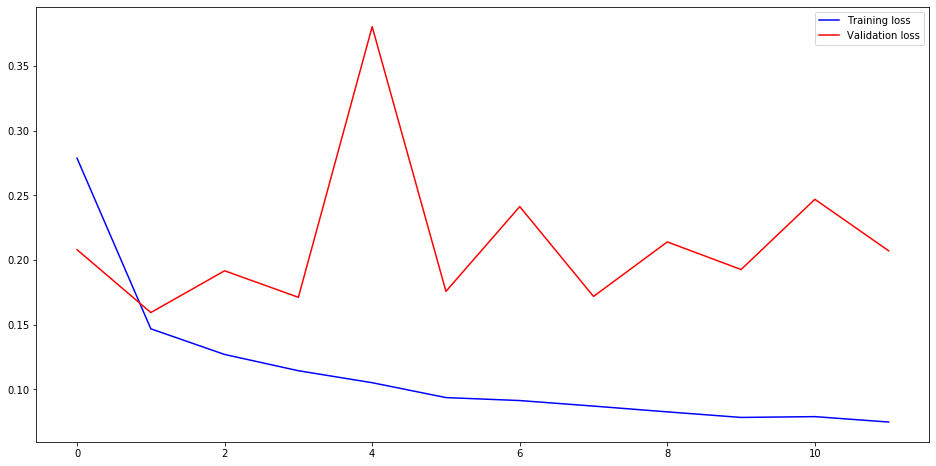

In [86]:
loss = multi_step_history.history['loss']
val_loss = multi_step_history.history['val_loss']
epochs = range(len(loss)) 
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.legend()
plt.show()

(9757, 7)
Prediction step : 1
               pred_1     fact_1
1985-01-01  54.904877  46.915170
1985-01-02  51.928452  44.941066
1985-01-03  48.798813  42.966961
1985-01-04  46.235855  42.966961
1985-01-05  42.363251  42.966961
42.806
0.962


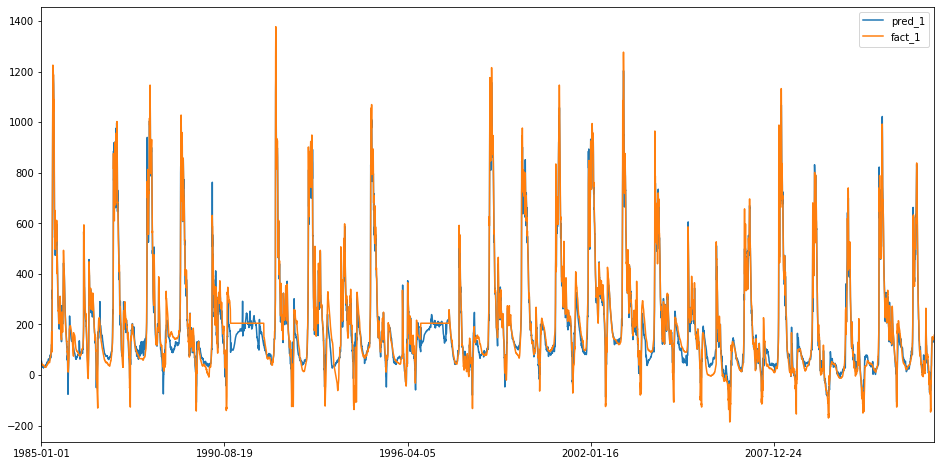

Prediction step : 2
               pred_1     fact_1     pred_2     fact_2
1985-01-01  54.904877  46.915170  68.680344  44.941066
1985-01-02  51.928452  44.941066  65.577255  42.966961
1985-01-03  48.798813  42.966961  62.343185  42.966961
1985-01-04  46.235855  42.966961  59.650436  42.966961
1985-01-05  42.363251  42.966961  55.255722  42.966961
49.29
0.95


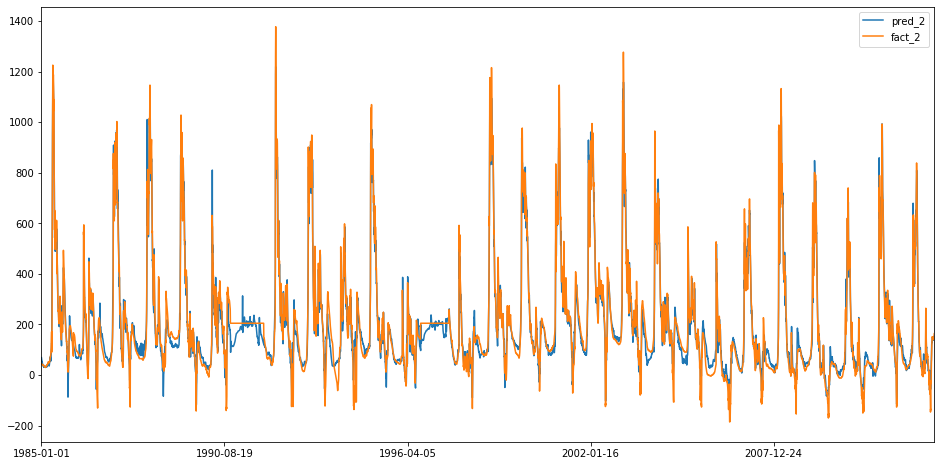

Prediction step : 3
               pred_1     fact_1     pred_2     fact_2     pred_3     fact_3
1985-01-01  54.904877  46.915170  68.680344  44.941066  57.689301  42.966961
1985-01-02  51.928452  44.941066  65.577255  42.966961  54.073669  42.966961
1985-01-03  48.798813  42.966961  62.343185  42.966961  50.371964  42.966961
1985-01-04  46.235855  42.966961  59.650436  42.966961  47.041229  42.966961
1985-01-05  42.363251  42.966961  55.255722  42.966961  42.376770  40.992856
55.66
0.937


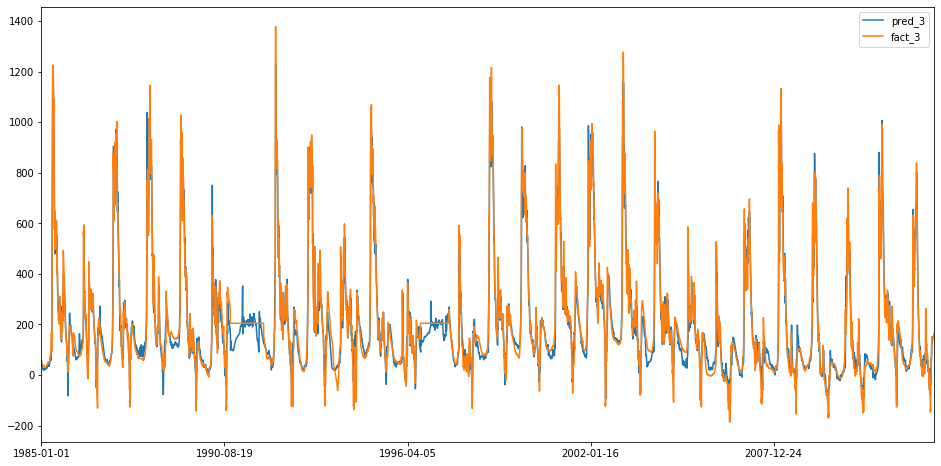

Prediction step : 4
               pred_1     fact_1     pred_2     fact_2     pred_3     fact_3  \
1985-01-01  54.904877  46.915170  68.680344  44.941066  57.689301  42.966961   
1985-01-02  51.928452  44.941066  65.577255  42.966961  54.073669  42.966961   
1985-01-03  48.798813  42.966961  62.343185  42.966961  50.371964  42.966961   
1985-01-04  46.235855  42.966961  59.650436  42.966961  47.041229  42.966961   
1985-01-05  42.363251  42.966961  55.255722  42.966961  42.376770  40.992856   

               pred_4     fact_4  
1985-01-01  63.062378  42.966961  
1985-01-02  59.709183  42.966961  
1985-01-03  56.336456  42.966961  
1985-01-04  53.246613  40.992856  
1985-01-05  48.820801  40.992856  
62.279
0.921


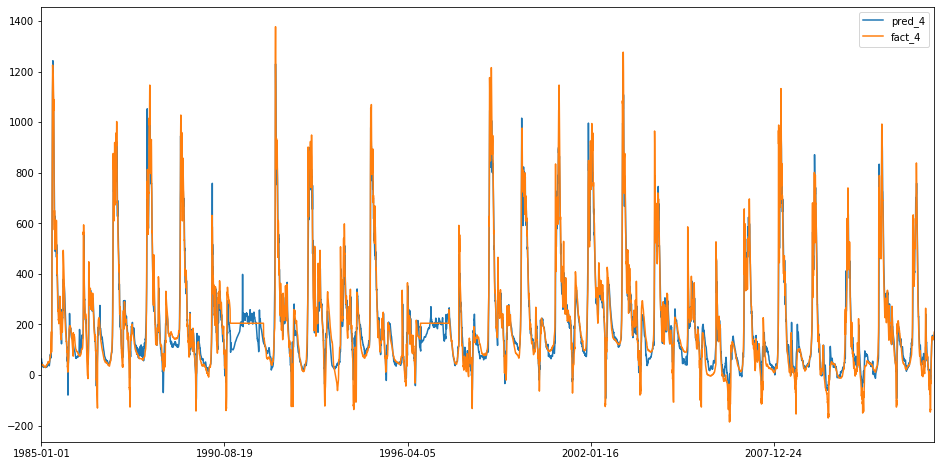

Prediction step : 5
               pred_1     fact_1     pred_2     fact_2     pred_3     fact_3  \
1985-01-01  54.904877  46.915170  68.680344  44.941066  57.689301  42.966961   
1985-01-02  51.928452  44.941066  65.577255  42.966961  54.073669  42.966961   
1985-01-03  48.798813  42.966961  62.343185  42.966961  50.371964  42.966961   
1985-01-04  46.235855  42.966961  59.650436  42.966961  47.041229  42.966961   
1985-01-05  42.363251  42.966961  55.255722  42.966961  42.376770  40.992856   

               pred_4     fact_4     pred_5     fact_5  
1985-01-01  63.062378  42.966961  59.936905  42.966961  
1985-01-02  59.709183  42.966961  56.006866  42.966961  
1985-01-03  56.336456  42.966961  52.067902  40.992856  
1985-01-04  53.246613  40.992856  48.264984  40.992856  
1985-01-05  48.820801  40.992856  43.363876  40.992856  
67.973
0.905


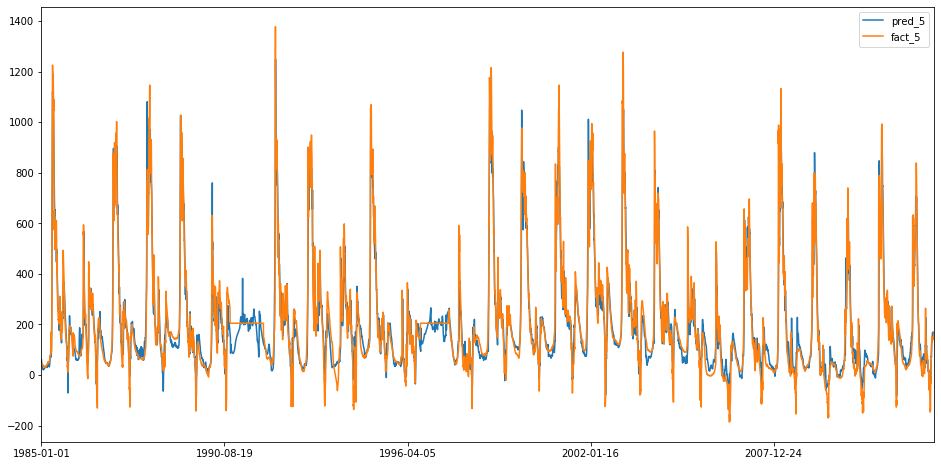

Prediction step : 6
               pred_1     fact_1     pred_2     fact_2     pred_3     fact_3  \
1985-01-01  54.904877  46.915170  68.680344  44.941066  57.689301  42.966961   
1985-01-02  51.928452  44.941066  65.577255  42.966961  54.073669  42.966961   
1985-01-03  48.798813  42.966961  62.343185  42.966961  50.371964  42.966961   
1985-01-04  46.235855  42.966961  59.650436  42.966961  47.041229  42.966961   
1985-01-05  42.363251  42.966961  55.255722  42.966961  42.376770  40.992856   

               pred_4     fact_4     pred_5     fact_5     pred_6     fact_6  
1985-01-01  63.062378  42.966961  59.936905  42.966961  63.173096  42.966961  
1985-01-02  59.709183  42.966961  56.006866  42.966961  60.091629  40.992856  
1985-01-03  56.336456  42.966961  52.067902  40.992856  56.670303  40.992856  
1985-01-04  53.246613  40.992856  48.264984  40.992856  53.414795  40.992856  
1985-01-05  48.820801  40.992856  43.363876  40.992856  49.224289  40.992856  
71.954
0.894


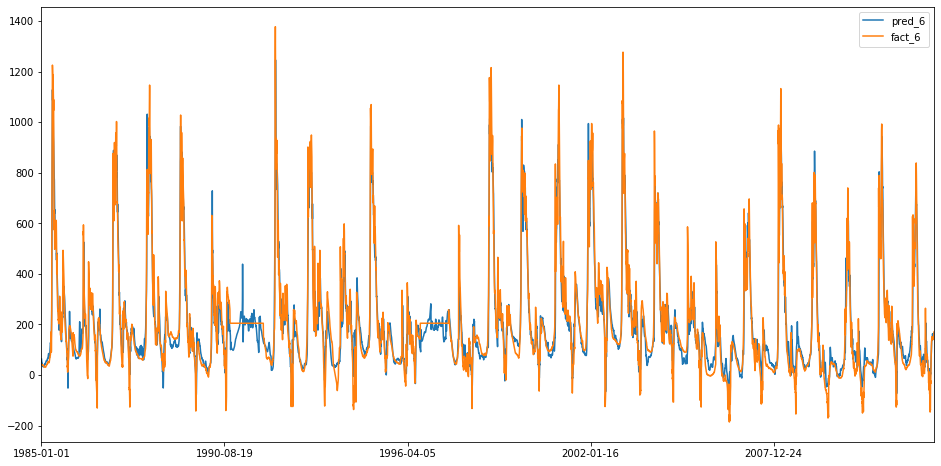

Prediction step : 7
               pred_1     fact_1     pred_2     fact_2     pred_3     fact_3  \
1985-01-01  54.904877  46.915170  68.680344  44.941066  57.689301  42.966961   
1985-01-02  51.928452  44.941066  65.577255  42.966961  54.073669  42.966961   
1985-01-03  48.798813  42.966961  62.343185  42.966961  50.371964  42.966961   
1985-01-04  46.235855  42.966961  59.650436  42.966961  47.041229  42.966961   
1985-01-05  42.363251  42.966961  55.255722  42.966961  42.376770  40.992856   

               pred_4     fact_4     pred_5     fact_5     pred_6     fact_6  \
1985-01-01  63.062378  42.966961  59.936905  42.966961  63.173096  42.966961   
1985-01-02  59.709183  42.966961  56.006866  42.966961  60.091629  40.992856   
1985-01-03  56.336456  42.966961  52.067902  40.992856  56.670303  40.992856   
1985-01-04  53.246613  40.992856  48.264984  40.992856  53.414795  40.992856   
1985-01-05  48.820801  40.992856  43.363876  40.992856  49.224289  40.992856   

               pre

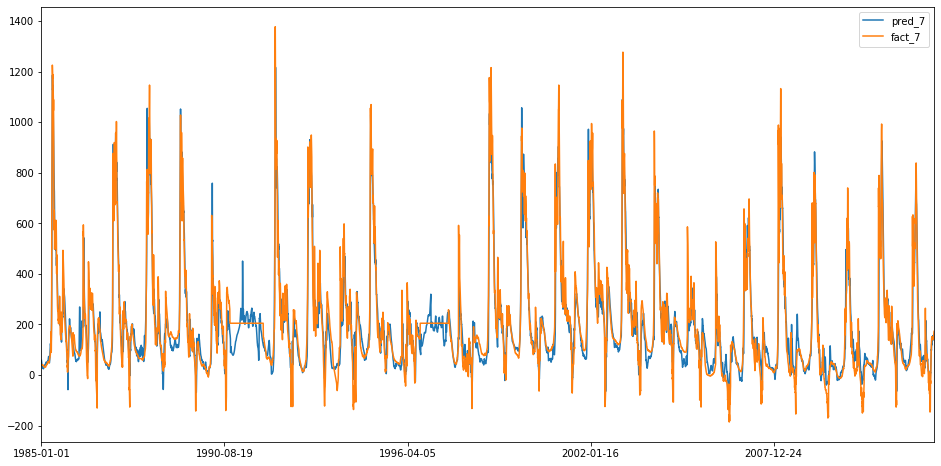

In [90]:
res_df_train = pd.DataFrame()
# compare train data and prediction
print(y_train_multi.shape)
for i in range(y_train_multi.shape[1]):
    print('Prediction step :', i + 1)
    train_df = pd.DataFrame(data={'pred_' + str(i+1): multi_step_model.predict(x_train_multi)[:,i], 'fact_' + str(i+1): y_train_multi[:,i]})
    train_df = train_df * data_std[6] + data_mean[6]
    train_df.index = df[:test_size-past_history-future_target].index.values
#     train_df = train_df[train_df.index.month.isin([5, 6, 7, 8, 9, 10])]
    res_df_train = pd.concat([res_df_train, train_df], sort=False, axis=1)
    train_df.to_excel('results/lstm_noT_{0}_{1}_train.xlsx'.format(river, i+1))
#     print(train_df.head())
    print(res_df_train.head())
#     print('Rcorr: ', round(train_df.corr().iloc[0, 1], 3))
    print(round(RMSE(train_df['fact_' + str(i+1)], train_df['pred_' + str(i+1)]), 3))
    print(round(NSE(train_df['fact_' + str(i+1)], train_df['pred_' + str(i+1)]), 3))
    train_df.plot()
#     train_df.plot(x='fact', y='pred', kind='scatter')
    plt.show()
res_df_train.to_excel('results/lstm_{0}_all_train.xlsx'.format(river))

Prediction step : 1
34.9
0.976


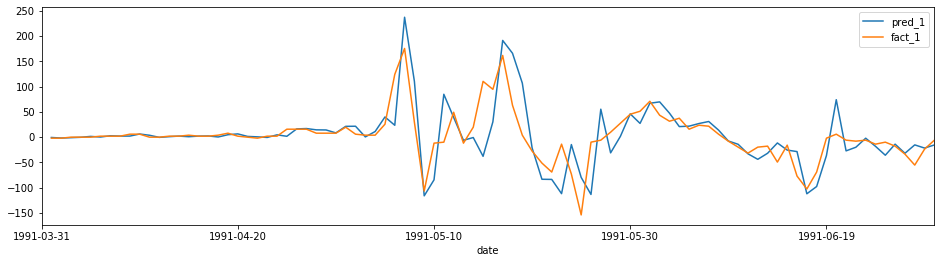

Prediction step : 2
52.925
0.946


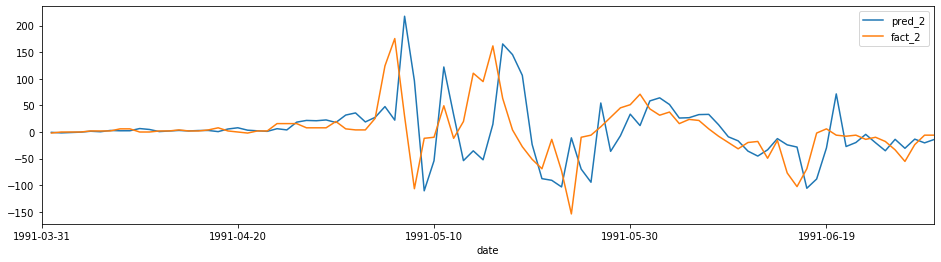

Prediction step : 3
70.723
0.903


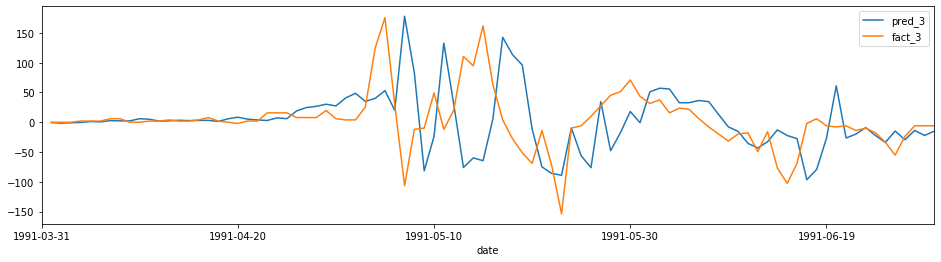

Prediction step : 4
86.773
0.854


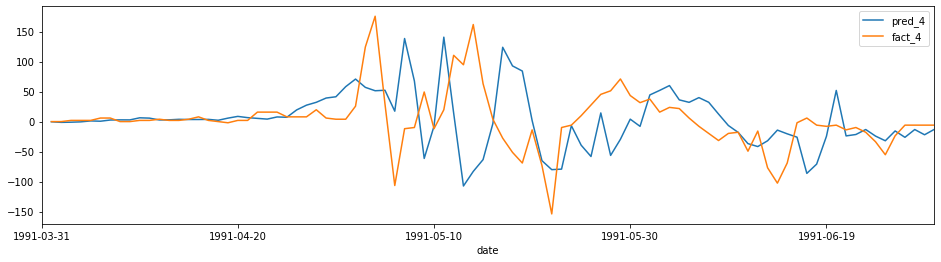

Prediction step : 5
96.765
0.819


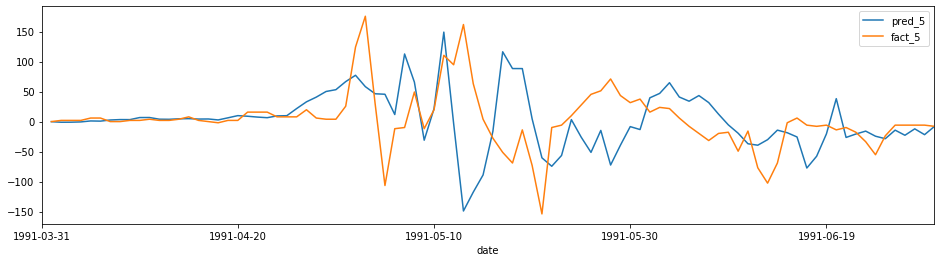

Prediction step : 6
104.617
0.788


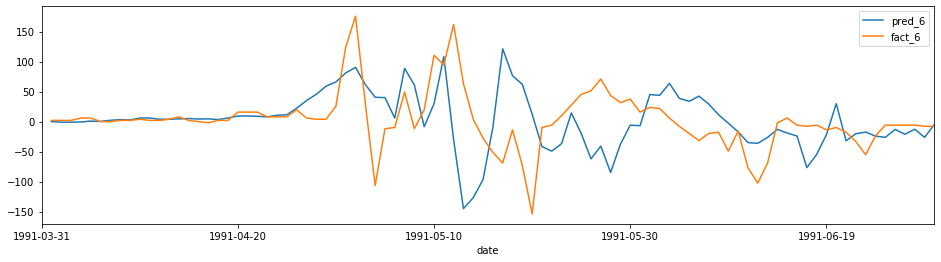

Prediction step : 7
111.912
0.758


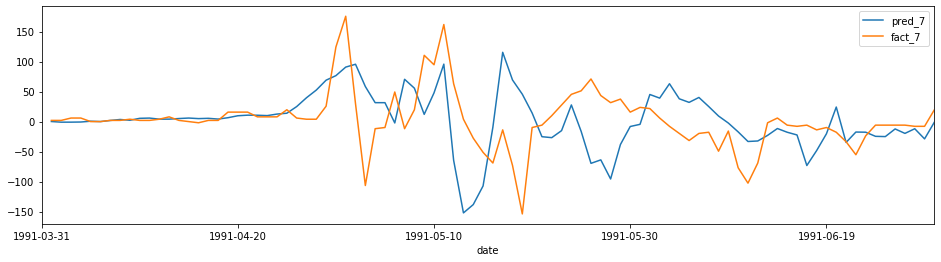

pred_1    56.500263
pred_2    53.675461
pred_3    48.586174
pred_4    45.892616
pred_5    46.992004
pred_6    45.130810
pred_7    45.825085
dtype: float32

In [148]:
res_df_test = pd.DataFrame()
# compare test data and prediction
for i in range(y_val_multi.shape[1]):
    print('Prediction step :', i + 1)
    val_df = pd.DataFrame(data={'pred_' + str(i+1): multi_step_model.predict(x_val_multi)[:,i], 'fact_' + str(i+1): y_val_multi[:,i]})
    val_df.index = df[past_history-1:(len(df)-test_size)-1].index
    val_df = val_df * data_std[6] + data_mean[6]
#     val_df = val_df[val_df.index.month.isin([5, 6, 7, 8, 9, 10])]
    res_df_test = pd.concat([res_df_test, val_df], sort=False, axis=1)
#     val_df.to_excel('results/lstm_noT_{0}_{1}_test.xlsx'.format(river, i+1))
#     print(val_df.head())
#     print('Rcorr: ', round(val_df.corr().iloc[0, 1], 3))
    print(round(RMSE(val_df['fact_' + str(i+1)], val_df['pred_' + str(i+1)]), 3))
    print(round(NSE(val_df['fact_' + str(i+1)], val_df['pred_' + str(i+1)]), 3))
    
    val_df['1991-03-31':'1991-06-30'].diff().plot(figsize=(16,4))
    plt.show()
res_df_test.loc['1991-03-31':'1991-06-30', [col for col in res_df_test.columns if 'pred_' in col]].diff().std()
#res_df_test.to_excel('results/lstm_{0}_all_test.xlsx'.format(river))

In [ ]:
# расчет метрики

# квадраты стандартных отклонений по гидропостам
STATION_COEFFS = {
        3019: 185.35707752426708,
        3027: 1223.8071616577856,
        3028: 1357.4062812989373,
        3029: 1520.7730161870682,
        3030: 1765.9217904996142,
        3035: 765.3703832632036,
        3041: 443.5766934006718,
        3045: 579.1353554017562,
        3050: 612.0471238561079,
        3230: 516.6669876251401
}

def rowwise_nse(row): 
    station_id = row.station_id
    station_coeff = STATION_COEFFS[station_id]
    
    actual = row['delta_stage_max_actual']
    predicted = row['delta_stage_max_predicted']
    return np.divide(np.square(np.subtract(predicted, actual)),
            station_coeff)

def score(actual_df, predicted_df):
    merged = pd.merge(
        left=predicted_df,
        right=actual_df,
        how='right',
        on=['date', 'station_id'],
        suffixes=('_predicted', '_actual'),
    )

    merged.delta_stage_max_predicted.fillna(0, inplace=True)
    merged['error'] = merged.apply(rowwise_nse, axis=1)
    merged.dropna(inplace=True)
    if len(merged) != len(actual_df):
        return 'length of predicted df does not match actual df'
    else:
        score = np.divide(merged['error'].sum(), len(merged))
        return score